In [15]:
from dotenv import load_dotenv

load_dotenv()

True

In [16]:
from langchain_core.tools import tool


@tool
def delegate(query: str):
    """Call to delegate something to the Tasks Team.
    The team can handle any task related demands, 
    such as querying, updating, adding, or deleting data from the tasks database."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return [query]


tools = [delegate]

In [17]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

In [18]:
from langchain_openai import ChatOpenAI

aurora = ChatOpenAI()
tasks_team = ChatOpenAI()

In [19]:
aurora = aurora.bind_tools(tools)

In [20]:
import operator
from typing import Annotated, Sequence

from langchain_core.messages import BaseMessage
from langchain_core.pydantic_v1 import BaseModel


class AgentState(BaseModel):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [26]:
from langchain_core.messages import SystemMessage, HumanMessage


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state.messages
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "aurora_node"
    # Otherwise if there is, we continue
    else:
        return "tasks_node"


# Define the function that calls the model
def aurora_node(state):
    messages = state.messages
    if not messages:
        messages = [SystemMessage(content="You are a personal assistant. You answer what you can, and delegate otherwise", name="Aurora")]
    response = aurora.invoke(messages)
    response.name = "Aurora"
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function to execute tools
def tasks_node(state):
    messages = state.messages
    messages.append(SystemMessage(content="You make stuff up regarding a person's tasks.", name="Tasks"))
    response = tasks_team.invoke(messages)
    response.name = "Tasks"
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [27]:
from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("aurora_node", aurora_node)
workflow.add_node("tasks_node", tasks_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("aurora_node")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "aurora_node",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "aurora_node": "aurora_node",
        "tasks_node": "tasks_node",
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tasks_node", "aurora_node")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

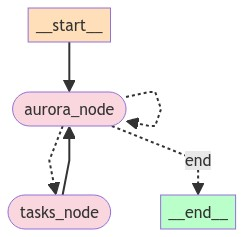

In [28]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [29]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="Good day, my good sir! How's the weather in London?")]}
for chunk in app.stream(inputs, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Good day, my good sir! How's the weather in London?
================================== Ai Message ==================================
Name: Aurora
Tool Calls:
  delegate (call_RonXL9hv7tMCXXQXIEckJcct)
 Call ID: call_RonXL9hv7tMCXXQXIEckJcct
  Args:
    query: weather in London


BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_RonXL9hv7tMCXXQXIEckJcct", 'type': 'invalid_request_error', 'param': 'messages.[2].role', 'code': None}}